In [33]:
import torch
import XAI_core
import datasets
import models
from matplotlib import pyplot as plt

In [32]:
%load_ext autoreload
%autoreload 2

In [36]:
model = models.get_model("vgg16", cuda = True)
dataset = datasets.ImageNetSubset(root = "D:\\imagenet")
loader = datasets.get_data_loader(dataset, batch_size = 1, shuffle = False)
explainer = XAI_core.ConceptExplainer(model, *dataset.mean_std())

tensor([0.4850, 0.4560, 0.4060])
tensor([0.2290, 0.2240, 0.2250])


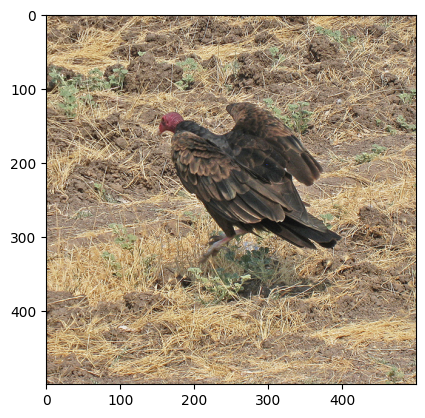

In [142]:
x,y = dataset[25]
x = x[None,:]
x_viz = dataset.prep_for_viz(x)
plt.imshow(x_viz[0])

In [143]:
from zennit.image import imgify, imsave

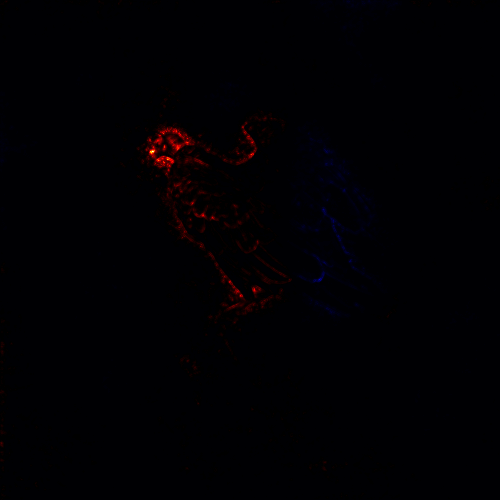

In [144]:
composite_args = dict(epsilon = 1e-6, gamma = 0.2)
explainer = XAI_core.ConceptExplainer(model, *dataset.mean_std(), composite_args = composite_args)

_, _, grad = explainer.explain(x.cuda())
grad = grad.sum(axis = 1).cpu()
imgify(grad, symmetric = True, cmap='coldnhot')